In [1]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np

import sys
sys.path.append("..")
from models import CompositeClassifier

In [2]:
x_train = np.load("X-1647041985-early-fusion-vectors-train.arr")
y_train = np.load("y-1647041985-train.arr")

x_test = np.load("X-1647097165-early-fusion-vectors-test.arr")
y_test = np.load("y-1647097165-test.arr")

## Different late fusion networks

In [3]:
def fit(models, x_trains, y_train, save=False):
    for model in models:
        models[model].fit(x_trains[model], y_train)
        if save:
            models[model].save_late_fusion_model()

def evaluate(models, x_tests, y_test):
    probs = {}
    for model in models:
        probs[model] = models[model].predict_proba(x_tests[model])[:,1]
        preds = np.where(probs[model] > 0.5, 1, 0)
        print("\n", "="*6, f"{model}", "="*6)
        print(f"ROC AUC score: {roc_auc_score(y_test, probs[model])}")
        print(f"Classification report:")
        print(classification_report(y_test, preds, digits=4))

    model = "No Skill"
    most_common_label = np.argmax(np.bincount(y_test.astype(int)))
    probs[model] = np.array([most_common_label for _ in range(len(y_test))], dtype=int)
    
    plt.figure(figsize=(14,6))
    for model in probs:
        fpr, tpr, _ = roc_curve(y_test, probs[model])
        # plot the roc curve for the model
        linestyle = "--" if model == "No Skill" else "solid"
        plt.plot(fpr, tpr, linestyle=linestyle, label=model)
        # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    _ = plt.legend()

In [4]:
models = {}
modules = ["malconv", "ember", "filepaths", "emulation"]

repo_root = "../"
params = {
"malconv_model_path": repo_root+'modules/sota/malconv/parameters/malconv.checkpoint',
"ember_2019_model_path": repo_root+'modules/sota/ember/parameters/ember_model.txt',
"filepath_model_path": repo_root+'modules/filepath/pretrained/1646930331-model.torch',
"filepath_bytes": repo_root+'modules/filepath/pretrained/keep_bytes-ed64-pl150-kb150-1646917941.pickle',
"emulation_model_path": repo_root+'modules/emulation/pretrained/1646990611-model.torch',
"emulation_apicalls": repo_root+'modules/emulation/pretrained/api_calls_preserved-ed96-pl150-kb600-1646926097.pickle',
}

models["Logistic Regression"] = CompositeClassifier(modules=modules, late_fusion_model="LogisticRegression", **params)
models["XGBClassifier"] = CompositeClassifier(modules=modules, late_fusion_model="XGBClassifier",**params)
models["MultiLayerPerceptron"] = CompositeClassifier(modules=modules, late_fusion_model="MultiLayerPerceptron",**params)

x_trains = dict([(model, x_train) for model in models])
x_tests = dict([(model, x_test) for model in models])


 ====== Logistic Regression ======
ROC AUC score: 0.9987736442550271
Classification report:
              precision    recall  f1-score   support

         0.0     0.9718    0.9625    0.9671      4982
         1.0     0.9859    0.9895    0.9877     13190

    accuracy                         0.9821     18172
   macro avg     0.9789    0.9760    0.9774     18172
weighted avg     0.9820    0.9821    0.9820     18172


 ====== XGBClassifier ======
ROC AUC score: 0.9990002218753243
Classification report:
              precision    recall  f1-score   support

         0.0     0.9755    0.9659    0.9707      4982
         1.0     0.9872    0.9908    0.9890     13190

    accuracy                         0.9840     18172
   macro avg     0.9813    0.9784    0.9798     18172
weighted avg     0.9840    0.9840    0.9840     18172


 ====== MultiLayerPerceptron ======
ROC AUC score: 0.9988568094571846
Classification report:
              precision    recall  f1-score   support

         0.0     

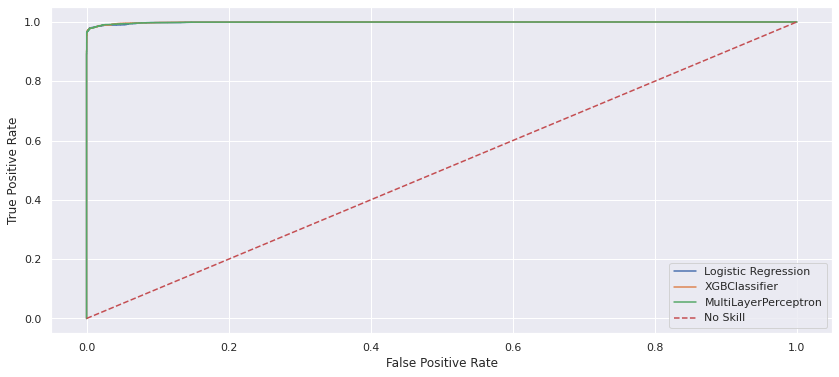

In [5]:
fit(models, x_trains, y_train)
evaluate(models, x_tests, y_test)

## Different modules

In [8]:
modulelist = [["malconv"], ["ember"], ["filepaths"], ["emulation"], 
            ["malconv", "ember", "filepaths", "emulation"], 
            ["malconv", "ember", "emulation"]]
models = {}
x_trains = {}
x_tests = {}
for modules in modulelist:
    name = "_".join(modules)
    if len(modules) == 4:
        name = "All"
    
    repo_root = "../"
    params = {
    "malconv_model_path": repo_root+'modules/sota/malconv/parameters/malconv.checkpoint',
    "ember_2019_model_path": repo_root+'modules/sota/ember/parameters/ember_model.txt',
    "filepath_model_path": repo_root+'modules/filepath/pretrained/1646930331-model.torch',
    "filepath_bytes": repo_root+'modules/filepath/pretrained/keep_bytes-ed64-pl150-kb150-1646917941.pickle',
    "emulation_model_path": repo_root+'modules/emulation/pretrained/1646990611-model.torch',
    "emulation_apicalls": repo_root+'modules/emulation/pretrained/api_calls_preserved-ed96-pl150-kb600-1646926097.pickle',
    }
    models[name] = CompositeClassifier(modules=modules, late_fusion_model="LogisticRegression", **params)
    x_trains[name] = models[name].get_cropped_x(modules, x_train)
    x_tests[name] = models[name].get_cropped_x(modules, x_test)


 ====== malconv ======
ROC AUC score: 0.6703612306806399
Classification report:
              precision    recall  f1-score   support

         0.0     0.1748    0.0187    0.0337      4982
         1.0     0.7228    0.9667    0.8272     13190

    accuracy                         0.7068     18172
   macro avg     0.4488    0.4927    0.4305     18172
weighted avg     0.5726    0.7068    0.6097     18172


 ====== ember ======
ROC AUC score: 0.9860326135421863
Classification report:
              precision    recall  f1-score   support

         0.0     0.8578    0.9843    0.9167      4982
         1.0     0.9937    0.9384    0.9653     13190

    accuracy                         0.9510     18172
   macro avg     0.9258    0.9614    0.9410     18172
weighted avg     0.9565    0.9510    0.9520     18172


 ====== filepaths ======
ROC AUC score: 0.9885937365417702
Classification report:
              precision    recall  f1-score   support

         0.0     0.9527    0.9267    0.9396     

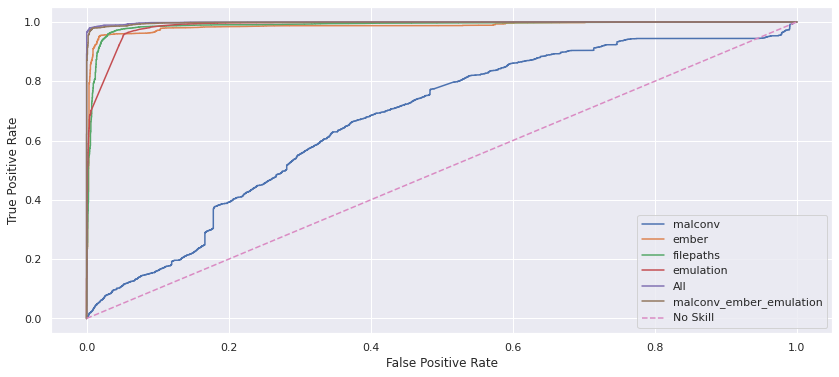

In [9]:
fit(models, x_trains, y_train)
evaluate(models, x_tests, y_test)


 ====== malconv ======
ROC AUC score: 0.6703612306806399
Classification report:
              precision    recall  f1-score   support

         0.0     0.1748    0.0187    0.0337      4982
         1.0     0.7228    0.9667    0.8272     13190

    accuracy                         0.7068     18172
   macro avg     0.4488    0.4927    0.4305     18172
weighted avg     0.5726    0.7068    0.6097     18172


 ====== ember ======
ROC AUC score: 0.9860326135421863
Classification report:
              precision    recall  f1-score   support

         0.0     0.8578    0.9843    0.9167      4982
         1.0     0.9937    0.9384    0.9653     13190

    accuracy                         0.9510     18172
   macro avg     0.9258    0.9614    0.9410     18172
weighted avg     0.9565    0.9510    0.9520     18172


 ====== filepaths ======
ROC AUC score: 0.9885937365417702
Classification report:
              precision    recall  f1-score   support

         0.0     0.9527    0.9267    0.9396     

(-0.05, 0.2)

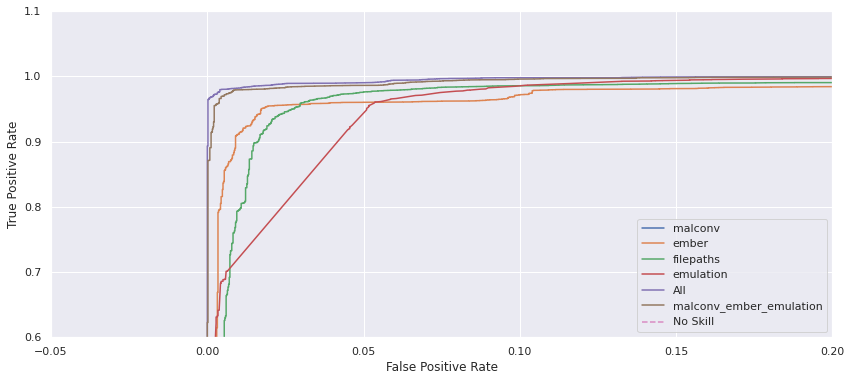

In [12]:
evaluate(models, x_tests, y_test)
plt.ylim([0.6, 1.1])
plt.xlim([-0.05, 0.2])